# Importing libaries

In [1]:
import dask.dataframe as dd #similar to pandas, used for parallel processing
import pandas as pd #pandas to create small dataframes 
import numpy as np #Do aritmetic operations on arrays
import matplotlib # matplotlib: used to plot graphs
#matplotlib.use('nbagg') : matplotlib uses this protocall which makes plots more user intractive like zoom in and zoom out
matplotlib.use('nbagg')
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots 
%matplotlib inline

# Importing Dataset

In [2]:
# train =dd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/train.csv')
# test = dd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/test.csv')
# weather_train = dd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_train.csv')
# weather_test = dd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_test.csv')
# building_metadata = dd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/building_metadata.csv')
train =pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/train.csv')
# test = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/test.csv')
weather_train = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_train.csv')
# weather_test = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_test.csv')
building_metadata = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/building_metadata.csv')
train.name = 'train'
# test.name = 'test'
weather_train.name = 'weather_train'
# weather_test.name = 'weather_test'
building_metadata.name = 'building_metadata'

In [3]:
# train.name
train.head()
#train.info()
# train.visualize()
#test.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
# Converting timestamp columns from all dataframes to datatime datatype
train['timestamp'] = dd.to_datetime(train['timestamp'])
# test['timestamp'] = dd.to_datetime(test['timestamp'])
weather_train['timestamp'] = dd.to_datetime(weather_train['timestamp'])
# weather_test['timestamp'] = dd.to_datetime(weather_test['timestamp'])

In [4]:
train['timestamp'].head()

0   2016-01-01
1   2016-01-01
2   2016-01-01
3   2016-01-01
4   2016-01-01
Name: timestamp, dtype: datetime64[ns]

In [5]:
# Function reducing dataframe size to fit into memory
# source : https://www.kaggle.com/c/ashrae-energy-prediction/discussion
def reduce_memory_usage(dataframe, verbose=True): 
    starting_memory = dataframe.memory_usage().sum() / 1024**2
    numeric_types = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for col in dataframe:
        data_type = dataframe[col].dtype
        if data_type in numeric_types:
            min_val = dataframe[col].min() #taking min and max value from each column
            max_val = dataframe[col].max()
            # assigning datatype as per the min and max value in column            
            if str(data_type)[:3] == 'int':
                if min_val > np.iinfo('int8').min and max_val < np.iinfo('int8').max:
                    dataframe[col] = dataframe[col].astype('int8')
                elif min_val > np.iinfo('int16').min and max_val < np.iinfo('int16').max:
                    dataframe[col] = dataframe[col].astype('int16')
                elif min_val > np.iinfo('int32').min and max_val < np.iinfo('int32').max:
                    dataframe[col] = dataframe[col].astype('int32')
                else:
                    dataframe[col] = dataframe[col].astype('int64') 
            else: 
                if min_val > np.finfo('float16').min and max_val < np.finfo('float16').max:
                    dataframe[col] = dataframe[col].astype('float16')
                elif min_val > np.finfo('float32').min and max_val < np.finfo('float32').max:
                    dataframe[col] = dataframe[col].astype('float32')
                else: 
                    dataframe[col] = dataframe[col].astype('float64') # useless line?
    end_memory = dataframe.memory_usage().sum() / 1024**2
    if verbose:
        #Checking how much memory reduced after applying this code        
        print('Memory usage decreased to {:.2f} mb ({:.2f}% decrease)'.format(end_memory, 100 * (starting_memory-end_memory) / starting_memory))

In [7]:
reduce_memory_usage(train)
# reduce_memory_usage(test)
reduce_memory_usage(weather_train)
# reduce_memory_usage(weather_test)
reduce_memory_usage(building_metadata)

Memory usage decreased to 289.19 mb (0.00% decrease)
Memory usage decreased to 3.07 mb (68.05% decrease)
Memory usage decreased to 0.03 mb (60.31% decrease)


# Initial Data Exploration 

In [8]:
print(building_metadata.shape)
print(building_metadata.columns)
# building.metadata.info()
# building_metadata.head()

(1449, 6)
Index(['site_id', 'building_id', 'primary_use', 'square_feet', 'year_built',
       'floor_count'],
      dtype='object')


In [9]:
print(building_metadata['primary_use'].value_counts())
print(building_metadata['year_built'].value_counts())

Education                        549
Office                           279
Entertainment/public assembly    184
Public services                  156
Lodging/residential              147
Other                             25
Healthcare                        23
Parking                           22
Warehouse/storage                 13
Manufacturing/industrial          12
Retail                            11
Services                          10
Technology/science                 6
Food sales and service             5
Utility                            4
Religious worship                  3
Name: primary_use, dtype: int64
1976.0    55
1966.0    23
1968.0    18
1919.0    17
1964.0    15
          ..
1934.0     1
1944.0     1
1916.0     1
1937.0     1
1918.0     1
Name: year_built, Length: 116, dtype: int64


In [10]:
building_metadata.isna().sum()
# almost half values of columns year_built and floor_count are empty. Either these columns needs to be imputed or dropped all together while building the model.

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built      774
floor_count    1094
dtype: int64

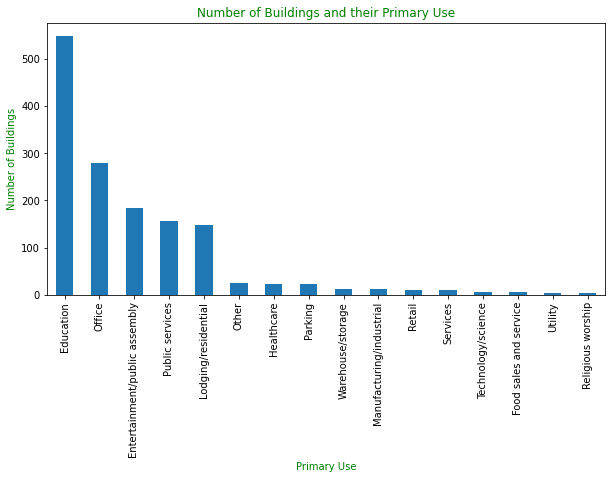

In [11]:
# Plotting, distribution of buildings as per their primary use
pl = building_metadata['primary_use'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Buildings and their Primary Use')
pl.set_xlabel('Primary Use')
pl.set_ylabel('Number of Buildings')
pl.xaxis.label.set_color('green')
pl.yaxis.label.set_color('green')
pl.title.set_color('green')
fig = pl.get_figure()
fig.savefig('Number of Buildings and their Primary Use',dpi=300)

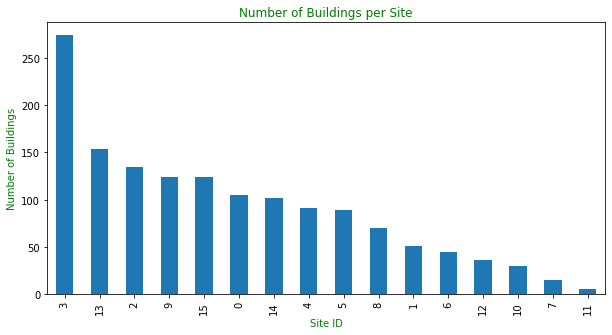

In [12]:
# Plotting, how many buildings are present in each site
pl = building_metadata['site_id'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Buildings per Site')
pl.set_xlabel('Site ID')
pl.set_ylabel('Number of Buildings')
pl.xaxis.label.set_color('green')
pl.yaxis.label.set_color('green')
pl.title.set_color('green')

In [13]:
# Plotting, how many buildings build in each year
# pl = building_metadata['year_built'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Buildings and their build year')
# pl.set_xlabel('Build Year')
# pl.set_ylabel('Number of Buildings')
# pl.xaxis.label.set_color('green')
# pl.yaxis.label.set_color('green')
# pl.title.set_color('green')

Text(0.5, 1.0, 'Number of Buildings and their build year')

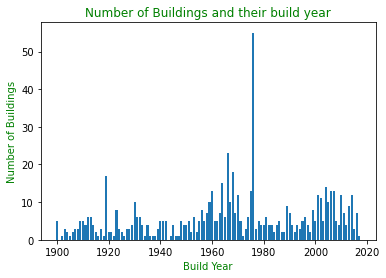

In [14]:
# Plotting, how many buildings build in each year
building_metadata['year_built'].sort_values().value_counts()
year=building_metadata['year_built'].sort_values().value_counts().keys()
building_number=building_metadata['year_built'].sort_values().value_counts().values
year
building_number

plt.bar(year, building_number)
plt.xlabel('Build Year', color='green')
plt.ylabel('Number of Buildings', color='green')
plt.title('Number of Buildings and their build year', color='green')


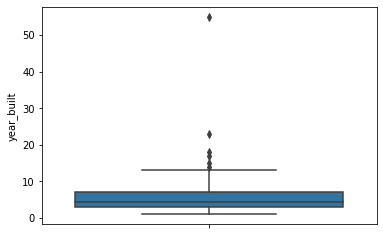

In [15]:
# boxplot of year built
year1=building_metadata['year_built'].sort_values().value_counts()
sns.boxplot(y=year1, data =building_metadata)
plt.show()

Text(0.5, 1.0, 'Number of Buildings and their square feet')

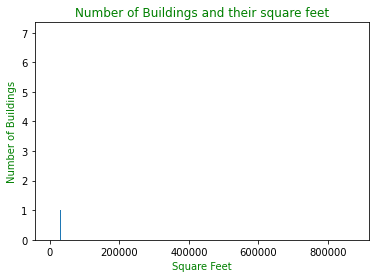

In [16]:
# plotting Number of Buildings and their square feet
building_metadata['square_feet'].sort_values().value_counts()
year=building_metadata['square_feet'].sort_values().value_counts().keys()
building_number=building_metadata['square_feet'].sort_values().value_counts().values
year
building_number

plt.bar(year, building_number)
plt.xlabel('Square Feet', color='green')
plt.ylabel('Number of Buildings', color='green')
plt.title('Number of Buildings and their square feet', color='green')

In [17]:
# square_feet=building_metadata['square_feet'].sort_values().value_counts()
# sns.boxplot(y=square_feet, data =building_metadata)
# plt.show()

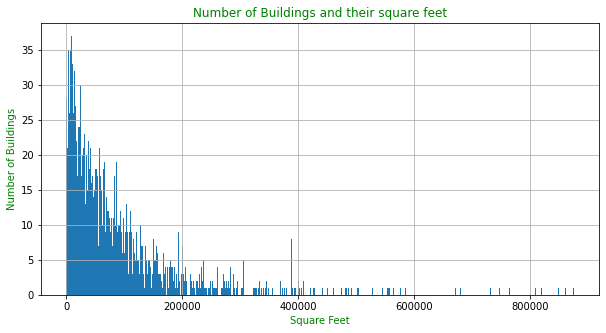

In [18]:
# histogram for Number of Buildings and their square feet
pl = building_metadata['square_feet'].hist(bins=500, figsize=(10,5))
pl.set_xlabel('Square Feet')
pl.set_ylabel('Number of Buildings')
pl.set_title('Number of Buildings and their square feet')
pl.xaxis.label.set_color('green')
pl.yaxis.label.set_color('green')
pl.title.set_color('green')

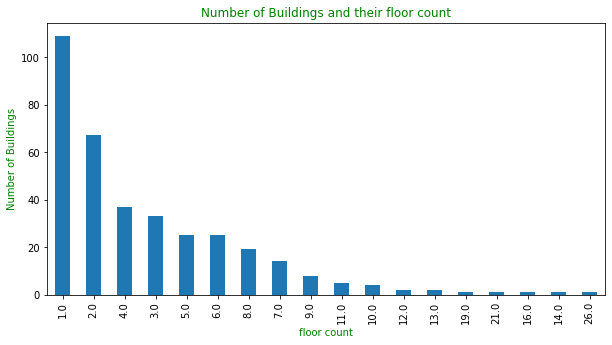

In [19]:
pl = building_metadata['floor_count'].value_counts().plot(kind='bar', figsize=(10,5), title='Number of Buildings and their floor count')
pl.set_xlabel('floor count')
pl.set_ylabel('Number of Buildings')
pl.xaxis.label.set_color('green')
pl.yaxis.label.set_color('green')
pl.title.set_color('green')

In [20]:
floor_count=building_metadata['floor_count'].sort_values().value_counts()
floor_count
# sns.boxplot(y=square_feet, data =building_metadata)
# plt.show()

1.0     109
2.0      67
4.0      37
3.0      33
5.0      25
6.0      25
8.0      19
7.0      14
9.0       8
11.0      5
10.0      4
12.0      2
13.0      2
19.0      1
21.0      1
16.0      1
14.0      1
26.0      1
Name: floor_count, dtype: int64

In [21]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =building_metadata["floor_count"].values
    var = np.sort(var,axis = None)
    print(var)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

[ 1.  1.  1. ... nan nan nan]
0 percentile value is 1.0
[ 1.  1.  1. ... nan nan nan]
10 percentile value is 2.0
[ 1.  1.  1. ... nan nan nan]
20 percentile value is 6.0
[ 1.  1.  1. ... nan nan nan]
30 percentile value is nan
[ 1.  1.  1. ... nan nan nan]
40 percentile value is nan
[ 1.  1.  1. ... nan nan nan]
50 percentile value is nan
[ 1.  1.  1. ... nan nan nan]
60 percentile value is nan
[ 1.  1.  1. ... nan nan nan]
70 percentile value is nan
[ 1.  1.  1. ... nan nan nan]
80 percentile value is nan
[ 1.  1.  1. ... nan nan nan]
90 percentile value is nan
100 percentile value is  nan


Since alot of the floor count values are nan, it is difficult to identify outliers

In [22]:
print(weather_train.shape)
print(weather_train.columns)
weather_train.info()
weather_train.head()

(139773, 9)
Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   site_id             139773 non-null  int8          
 1   timestamp           139773 non-null  datetime64[ns]
 2   air_temperature     139718 non-null  float16       
 3   cloud_coverage      70600 non-null   float16       
 4   dew_temperature     139660 non-null  float16       
 5   precip_depth_1_hr   89484 non-null   float16       
 6   sea_level_pressure  129155 non-null  float16       
 7   wind_direction      133505 non-null  float16       
 8   wind_speed          139469 non-null  float16       
dtypes: datetime64[ns](1), float16(7), int8(1)
memor

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.00000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.09375,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.09375,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.59375,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.00000,-1.0,1020.0,250.0,2.599609


In [23]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

US Seasons:

Summer: June - August 

Fall: September - November

Winter: December - February

Spring: March - May 

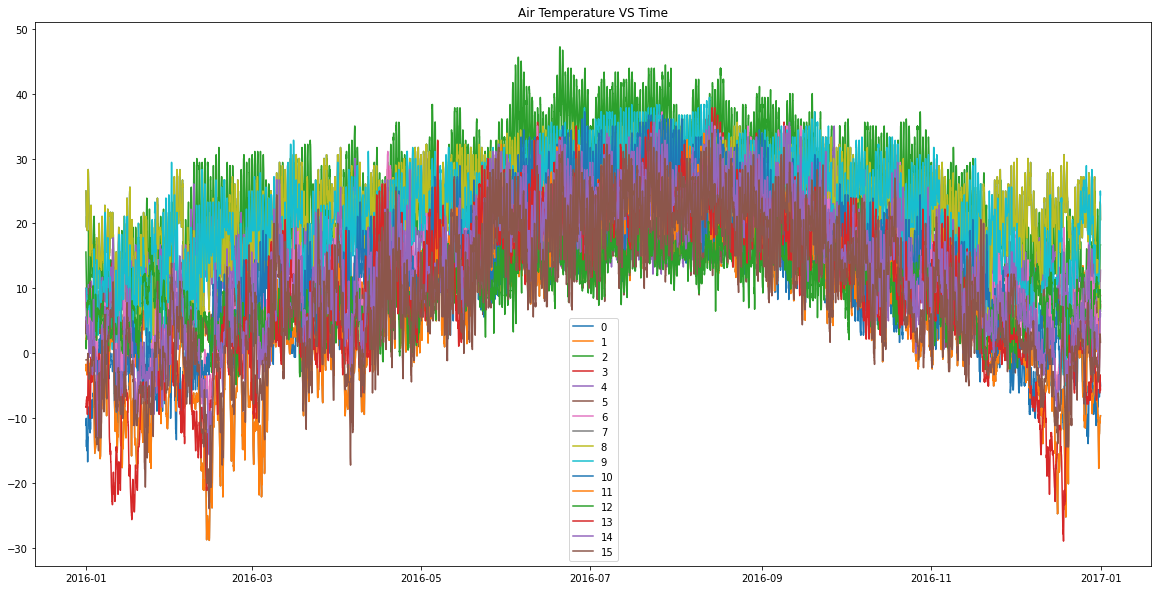

In [24]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
# inspiration for below code: https://www.kaggle.com/c/ashrae-energy-prediction/discussion
plt.figure(figsize=(20,10))
plt.title('Air Temperature VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    air_temperature = weather_train[weather_train['site_id']==sid]['air_temperature']
    labels[sid], = plt.plot(time, air_temperature, label=sid)
plt.legend(handles=labels)
plt.show()


1. Winter months have low temperatures for each site, similarly high temperatures in summer months.
2. All the sites have different temparature ranges, meaning some sites are colder than the others.

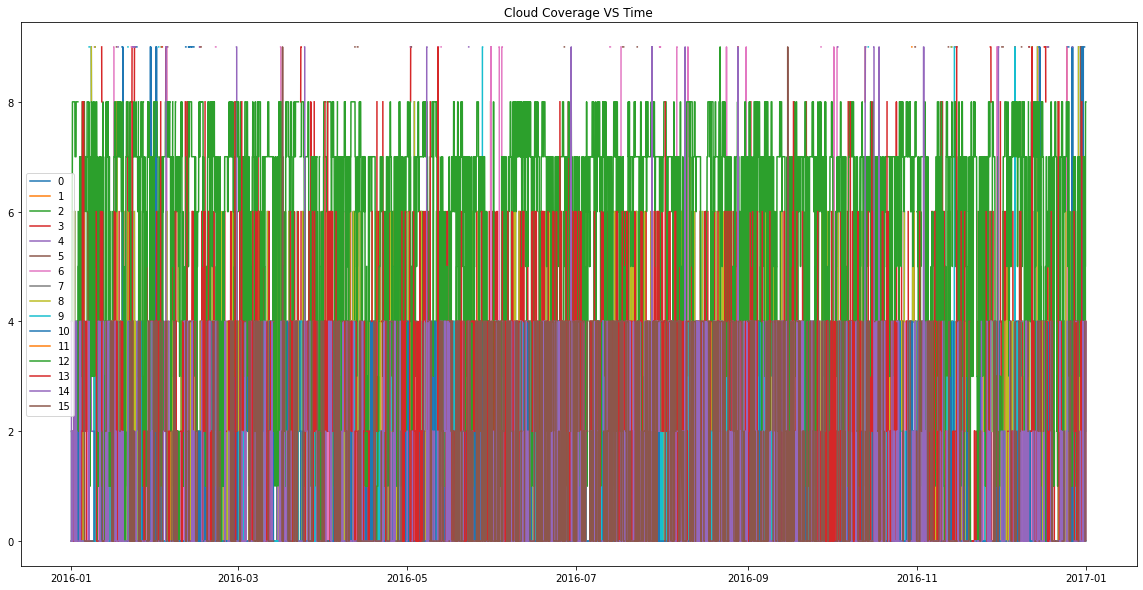

In [25]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
plt.figure(figsize=(20,10))
plt.title('Cloud Coverage VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    cloud_coverage = weather_train[weather_train['site_id']==sid]['cloud_coverage']
    labels[sid], = plt.plot(time, cloud_coverage, label=sid)
plt.legend(handles=labels)
plt.show()


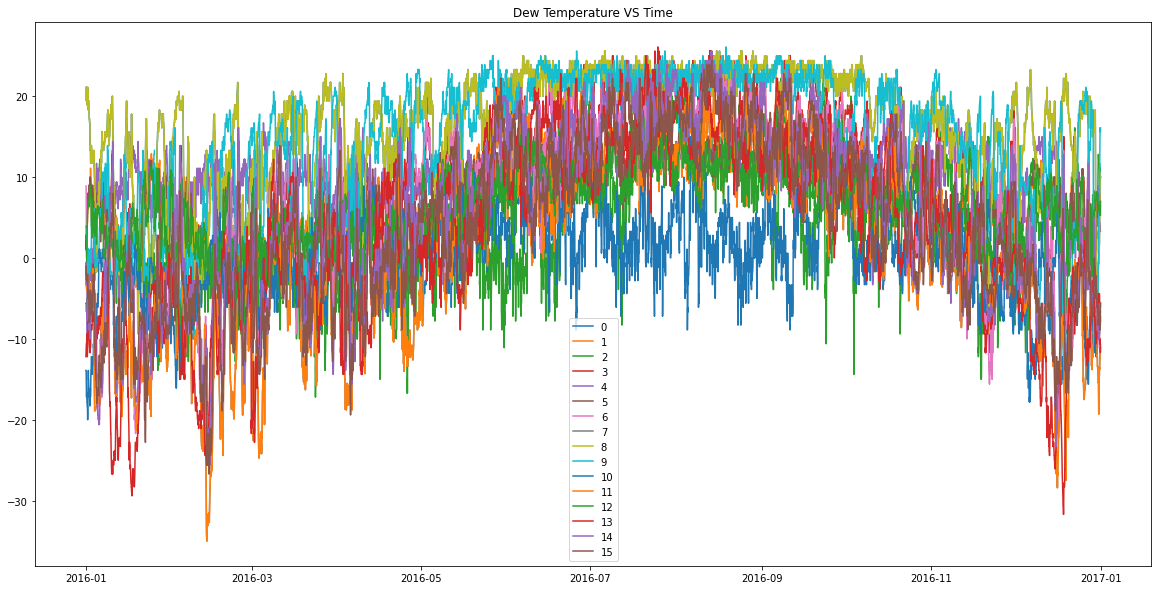

In [26]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
plt.figure(figsize=(20,10))
plt.title('Dew Temperature VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    dew_temperature = weather_train[weather_train['site_id']==sid]['dew_temperature']
    labels[sid], = plt.plot(time, dew_temperature, label=sid)
plt.legend(handles=labels)
plt.show()


The dew point is the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity (RH) of 100%. At this point the air cannot hold more water in the gas form.

1. In the summer months site id 0 has least dew temparature than all the other sites

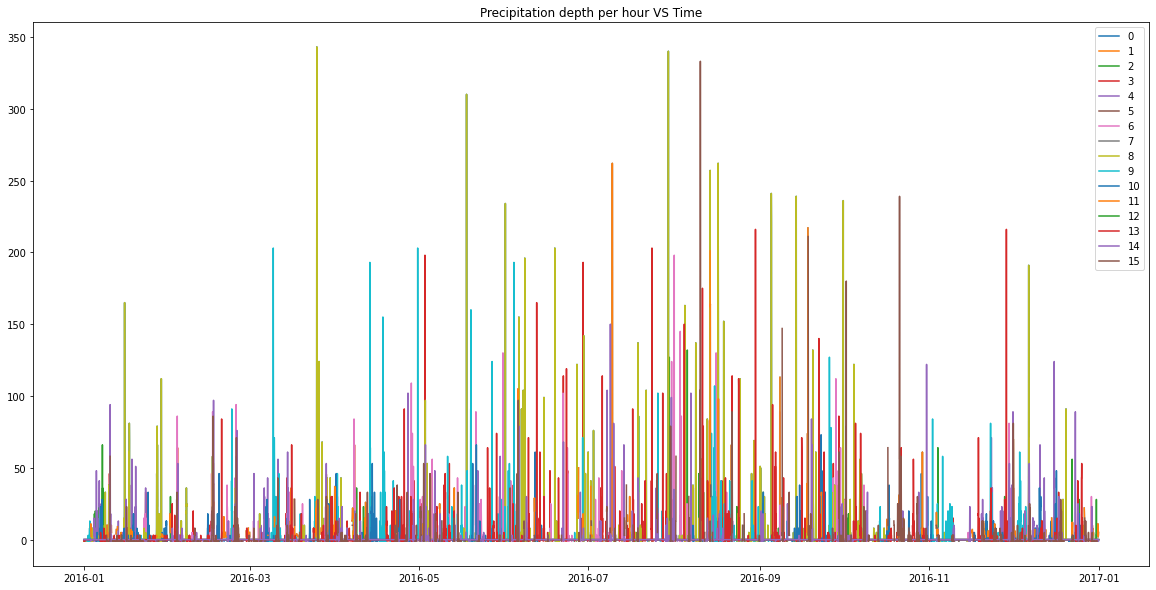

In [27]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
plt.figure(figsize=(20,10))
plt.title('Precipitation depth per hour VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    precip_depth_1_hr = weather_train[weather_train['site_id']==sid]['precip_depth_1_hr']
    labels[sid], = plt.plot(time, precip_depth_1_hr, label=sid)
plt.legend(handles=labels)
plt.show()

The precipitation depth indicates to what depth liquid precipitation would cover a horizontal surface in an observation period if nothing could drain, evaporate or percolate from this surface. The precipitation depth of 1 mm corresponds to a liquid quantity of 1 litre to 1 m² of ground area.
1. Largest precipation values are for site id 8 and then for 15, these sites must observe heavy rain falls.

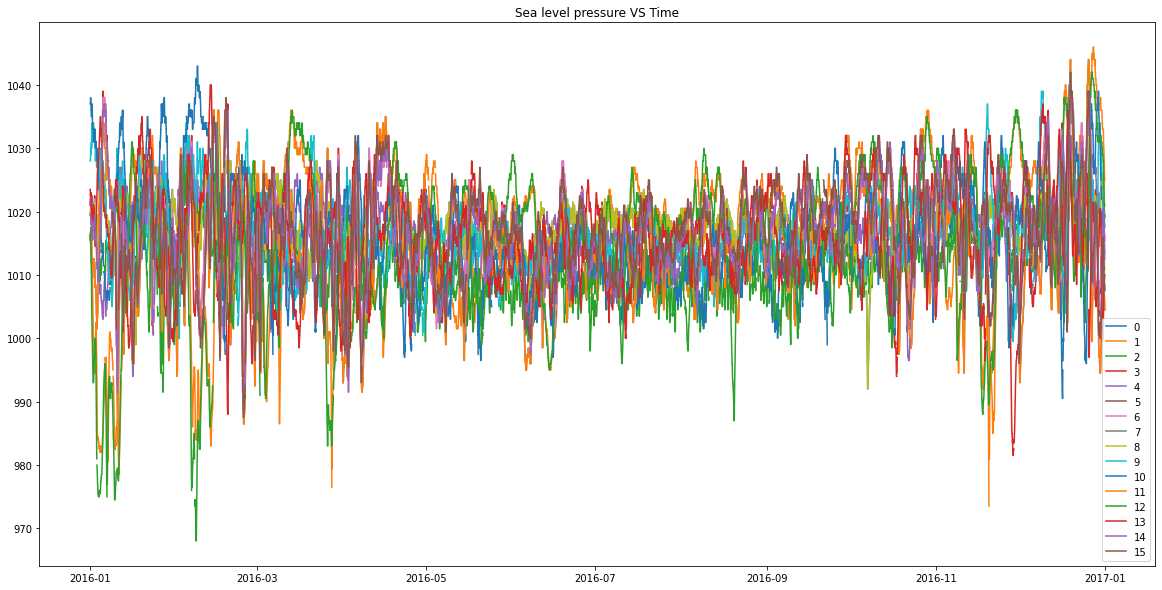

In [28]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
plt.figure(figsize=(20,10))
plt.title('Sea level pressure VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    sea_level_pressure = weather_train[weather_train['site_id']==sid]['sea_level_pressure']
    labels[sid], = plt.plot(time, sea_level_pressure, label=sid)
plt.legend(handles=labels)
plt.show()

Pressure caused by the weight of the air. At sea level it has an average value of one atmosphere and gradually decreases as the altitude increases. 
1. Its values are changing alot.
2. During winter months (start and end of the plot), the values are changing even more.

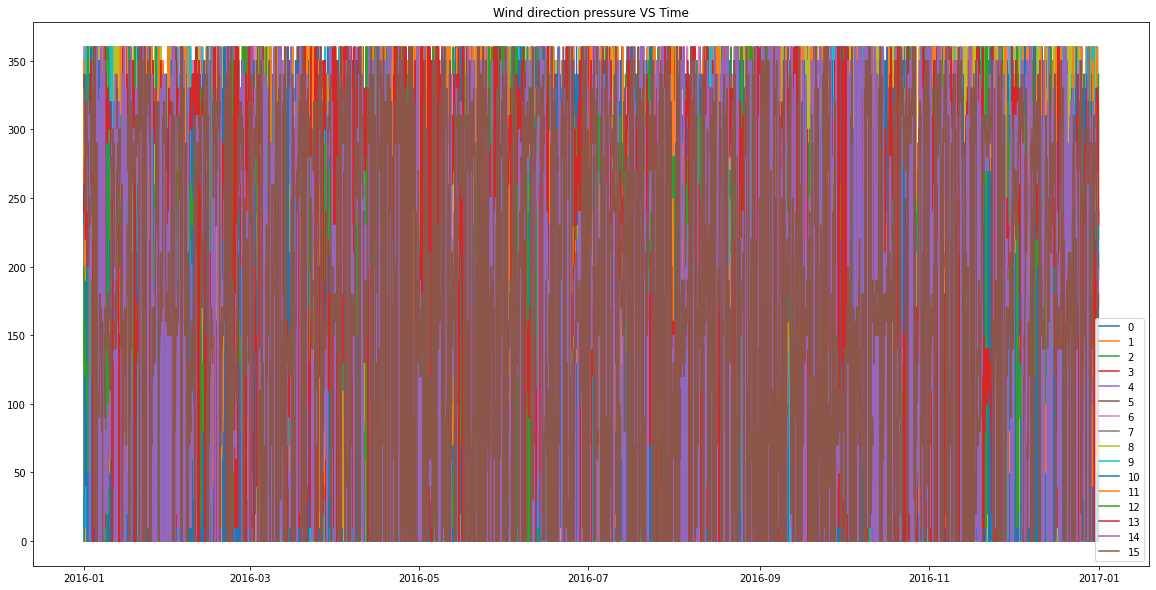

In [29]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
plt.figure(figsize=(20,10))
plt.title('Wind direction pressure VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    wind_direction = weather_train[weather_train['site_id']==sid]['wind_direction']
    labels[sid], = plt.plot(time, wind_direction, label=sid)
plt.legend(handles=labels)
plt.show()

Complete overlap, can't deduct anything

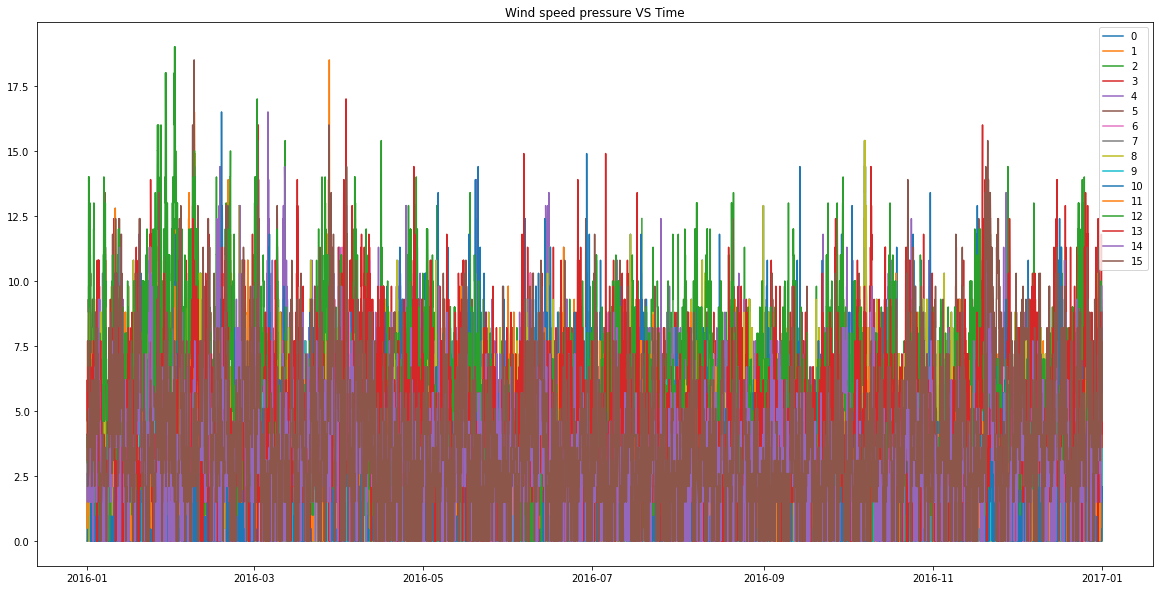

In [30]:
# 'air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed'
plt.figure(figsize=(20,10))
plt.title('Wind speed pressure VS Time')
labels = [0] * (max(weather_train['site_id'])+1)
for sid in range(max(weather_train['site_id'])+1):
    time = weather_train[weather_train['site_id']==sid ]['timestamp']
    wind_speed = weather_train[weather_train['site_id']==sid]['wind_speed']
    labels[sid], = plt.plot(time, wind_speed, label=sid)
plt.legend(handles=labels)
plt.show()

In [31]:

# from matplotlib import pyplot
# series = pd.read_csv('E:/pgduoh/Project/ashrae-energy-prediction/weather_train.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
# series.plot(kind='kde')
# pyplot.show()

In [32]:
print(train.shape)
print(train.columns)
train.info()
train.head()

(20216100, 4)
Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
 #   Column         Dtype         
---  ------         -----         
 0   building_id    int16         
 1   meter          int8          
 2   timestamp      datetime64[ns]
 3   meter_reading  float32       
dtypes: datetime64[ns](1), float32(1), int16(1), int8(1)
memory usage: 289.2 MB


,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


Meter 
0: electricity
1: chilled water
2: steam
3: hot water

In [33]:
# train.groupby(['meter', 'timestamp']).size().groupby(level=0).count()
# train.groupby(['meter', 'timestamp']).size().reset_index().groupby('building_id')[[0]].max()
# train.groupby(['meter', 'timestamp']).size()
train.groupby(['meter', 'timestamp'])['building_id'].count().groupby(level=0).median()
train.groupby(['meter', 'timestamp'])['building_id'].count().groupby(level=0).mean()

meter
0    1373.054417
1     476.142987
2     308.368966
3     143.902209
Name: building_id, dtype: float64

most of the buildings have electricity meters

In [34]:
# Output variable analysis
pd.DataFrame(train.groupby('meter')['meter_reading'] \
                 .describe() \
                 .astype(int)) \
                 .sort_values('count',
                              ascending=False)

,count,mean,std,min,25%,50%,75%,max
meter,,,,,,,,
0,12060910,170,380,0,19,62,170,79769
1,4182440,633,7988,0,11,120,464,880374
2,2708713,13882,418313,0,45,257,1035,21904700
3,1264037,385,2508,0,0,39,241,160187


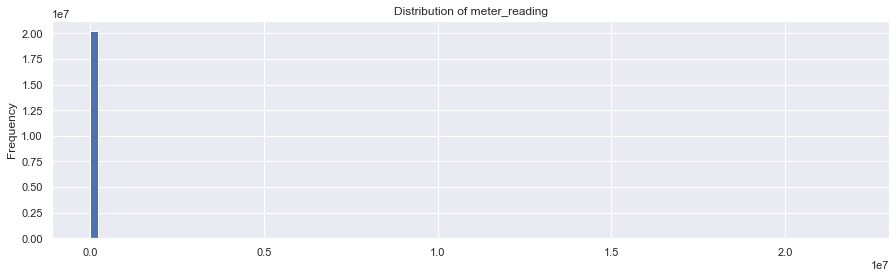

In [114]:
# plotting distribution of output variable
# extremly skewed
train['meter_reading'].plot(kind='hist',
                        bins=100,
                        figsize=(15, 4),
                       title='Distribution of meter_reading')
plt.show()

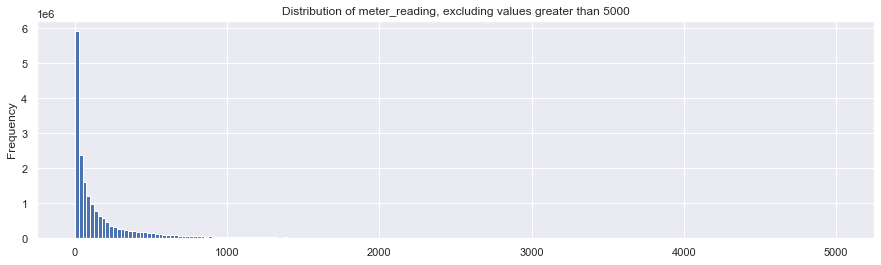

In [115]:
train.query('meter_reading < 5000')['meter_reading'] \
    .plot(kind='hist',
          figsize=(15, 4),
          title='Distribution of meter_reading, excluding values greater than 5000',
          bins=200)
plt.show()

<AxesSubplot:title={'center':'Meter 0'}, xlabel='timestamp'>

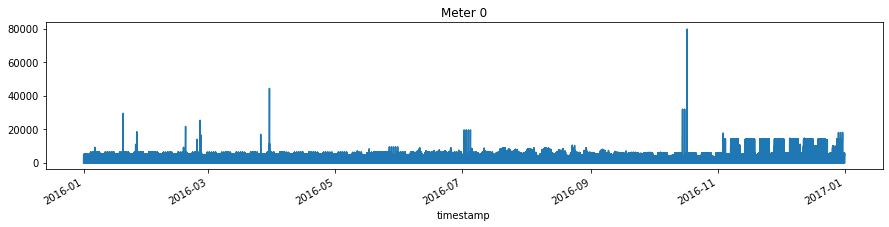

In [37]:
bid=train['building_id'].tolist()
# bid
train.query('building_id in @bid and meter == 0') \
    .set_index('timestamp')['meter_reading'].plot(figsize=(15, 3),
                                                 title='Meter 0')

<AxesSubplot:title={'center':'Meter 1'}, xlabel='timestamp'>

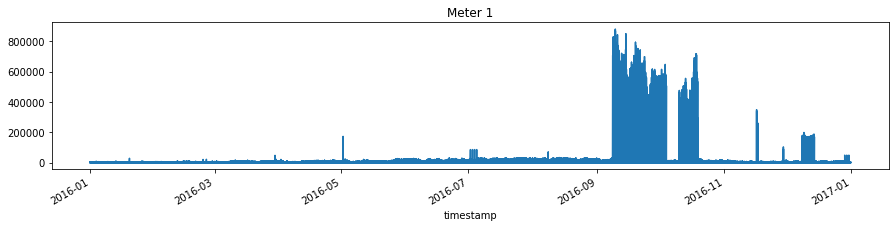

In [38]:
bid=train['building_id'].tolist()
# print(bid)
train.query('building_id in @bid and meter == 1') \
    .set_index('timestamp')['meter_reading'].plot(figsize=(15, 3),
                                                 title='Meter 1')

<AxesSubplot:title={'center':'Meter 2'}, xlabel='timestamp'>

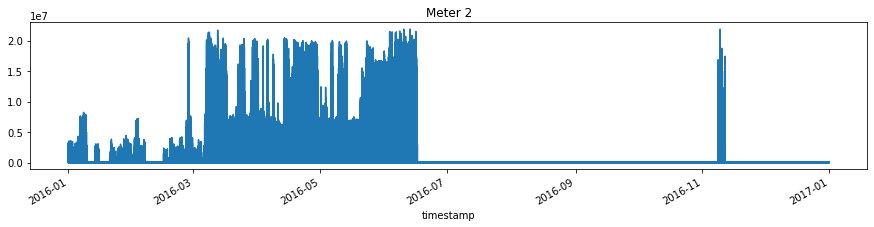

In [39]:
bid=train['building_id'].tolist()
# print(bid)
train.query('building_id in @bid and meter == 2') \
    .set_index('timestamp')['meter_reading'].plot(figsize=(15, 3),
                                                 title='Meter 2')

<AxesSubplot:title={'center':'Meter 3'}, xlabel='timestamp'>

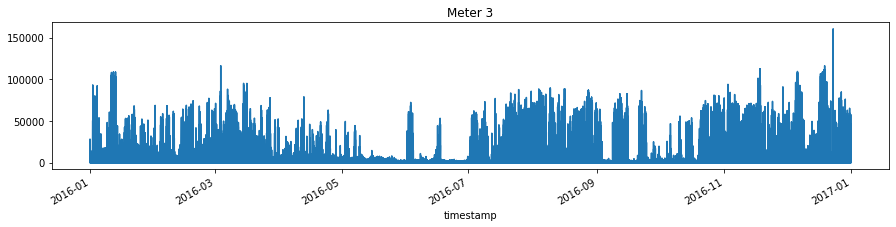

In [40]:
bid=train['building_id'].tolist()
# print(train['meter'].tolist())
# print(bid)
# print(train.query('building_id in @bid and meter == 3') \
#     .set_index('timestamp')['meter_reading'])
train.query('building_id in @bid and meter == 3') \
    .set_index('timestamp')['meter_reading'].plot(figsize=(15, 3),
                                                 title='Meter 3')

<AxesSubplot:title={'center':'Meter 0, building 0, year 2016'}, xlabel='timestamp'>

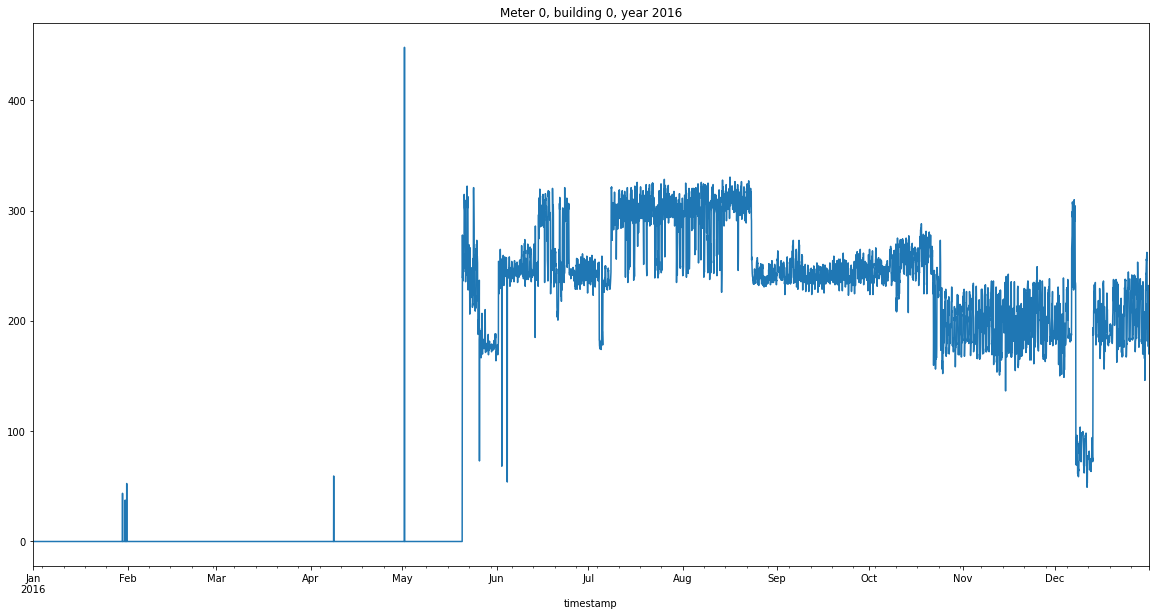

In [41]:
bid=train['building_id'].tolist()
# print(train.timestamp.dt.month)
month=1
# print(time)
# bid
train.query('building_id ==0 and meter == 0 and timestamp.dt.year==2016') \
    .set_index('timestamp')['meter_reading'].plot(figsize=(20, 10),
                                                 title='Meter 0, building 0, year 2016')

c:\python\python391\lib\site-packages\pandas\core\computation\expr.py:633: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  v = getattr(resolved, attr)


<AxesSubplot:title={'center':'Meter 0, building 0, week 52'}, xlabel='timestamp'>

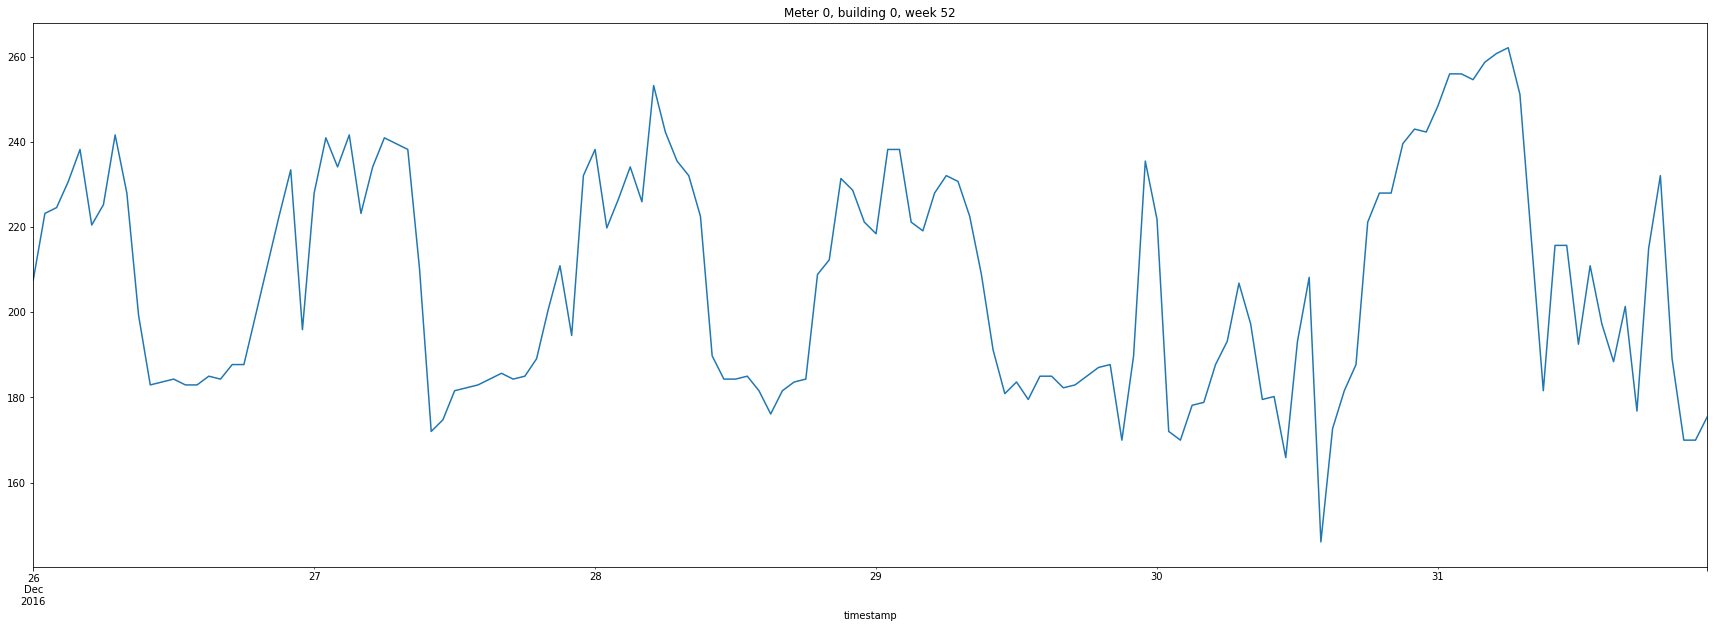

In [42]:
# bid=train['building_id'].tolist()
# start = datetime.time(14,50,0)
# end = datetime.time(18,0,0)
# print(train.between_time('2016-01-10 00:00:00','2016-01-16 00:00:00'))
month=1
# print(time)
# bid
train.query('building_id ==0 and meter == 0 and timestamp.dt.year==2016 and timestamp.dt.week==52') \
    .set_index('timestamp')['meter_reading'].plot(figsize=(30, 10),
                                                 title='Meter 0, building 0, week 52')

Monday: 26 December 2016
Saturday: 31 December 2016
1. At nights the meter readings drops as expected.

# Data Wrangling

In [8]:
# Merging all training data frames using left join
train_merged = train.merge(building_metadata, on='building_id', how='left')
train_merged = train_merged.merge(weather_train, on=['site_id','timestamp'], how='left')

In [44]:
train_merged.describe()

,building_id,meter,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,2.021610e+07,8088455.0,3506933.0,2.011944e+07,11390735.0,2.011596e+07,16467077.0,18984431.0,18767052.0,2.007242e+07
mean,7.992780e+02,6.624412e-01,2.117122e+03,7.992232e+00,1.077830e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,4.269133e+02,9.309921e-01,1.532356e+05,5.099060e+00,1.171424e+05,NaN,0.0,0.000000e+00,0.0,0.000000e+00,NaN,NaN,NaN,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.830000e+02,1900.0,1.0,-2.890625e+01,0.0,-3.500000e+01,-1.0,968.0,0.0,0.000000e+00
25%,3.930000e+02,0.000000e+00,1.830000e+01,3.000000e+00,3.252700e+04,1951.0,1.0,8.601562e+00,0.0,0.000000e+00,0.0,1011.5,70.0,2.099609e+00
50%,8.950000e+02,0.000000e+00,7.877500e+01,9.000000e+00,7.270900e+04,1969.0,3.0,1.670312e+01,0.0,8.898438e+00,0.0,1016.0,180.0,3.099609e+00
75%,1.179000e+03,1.000000e+00,2.679840e+02,1.300000e+01,1.391130e+05,1993.0,6.0,2.409375e+01,4.0,1.609375e+01,0.0,1020.5,280.0,4.601562e+00
max,1.448000e+03,3.000000e+00,2.190470e+07,1.500000e+01,8.750000e+05,2017.0,26.0,4.718750e+01,9.0,2.609375e+01,343.0,1046.0,360.0,1.900000e+01


In [9]:
#Creating fetures from timestamp column
train_merged['month'] = train_merged.timestamp.dt.month
train_merged['weekday'] = train_merged.timestamp.dt.weekday
train_merged['hour'] = train_merged.timestamp.dt.hour

In [8]:
# Creating if a date is holiday feature
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

df = pd.DataFrame()
df['Date'] = train_merged.timestamp.dt.date
# print(df['Date'].min())
# print(df['Date'].max())

cal = calendar()
holidays = cal.holidays(start=df['Date'].min(), end=df['Date'].max())

# df['Holiday'] = df['Date'].isin(holidays)
# print (df)
train_merged['is_holiday'] = df['Date'].isin(holidays)
train_merged.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,month,weekday,hour,is_holiday
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1,4,0,False
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1,4,0,False
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1,4,0,False
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1,4,0,False
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,1,4,0,False


Dropping un-necessary features

In [47]:
# Since timestamp feature is broken into multiple features, it can be dropped now.
train_merged.drop(['timestamp'], axis=1, inplace=True)

In [48]:
# sea_level_pressure, wind_direction, wind_speed columns are almost overlapping, these can aldo be dropped
train_merged.drop(['sea_level_pressure', 'wind_direction', 'wind_speed'], axis=1, inplace=True)

In [49]:
train_merged.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,weekday,hour,is_holiday
0,0,0,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1,4,0,False
1,1,0,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1,4,0,False
2,2,0,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1,4,0,False
3,3,0,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1,4,0,False
4,4,0,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1,4,0,False


In [50]:
y_train = train_merged['meter_reading']
X_train = train_merged.drop('meter_reading', axis=1)

In [51]:
X_train.head()
X_train.columns

Index(['building_id', 'meter', 'site_id', 'primary_use', 'square_feet',
       'year_built', 'floor_count', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'month', 'weekday', 'hour',
       'is_holiday'],
      dtype='object')

# Encoding of features

In [52]:
# Label encoding primary use feature
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(X_train.primary_use)
# LabelEncoder()
list(le.classes_)

X_train.primary_use = le.transform(X_train.primary_use)


In [53]:
X_train.primary_use.unique() #total 16 type of buildings

array([ 0,  4,  6,  1,  7, 11,  8,  9, 15,  2, 10,  3, 14, 13,  5, 12])

In [54]:
# Encoding is_holiday feature to binary form
X_train["is_holiday"] = X_train["is_holiday"].astype(int)
X_train.head()

,building_id,meter,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,month,weekday,hour,is_holiday
0,0,0,0,0,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1,4,0,0
1,1,0,0,0,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1,4,0,0
2,2,0,0,0,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1,4,0,0
3,3,0,0,0,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1,4,0,0
4,4,0,0,0,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1,4,0,0


In [123]:
train_merged.drop(['is_holiday'], axis=1, inplace=True)

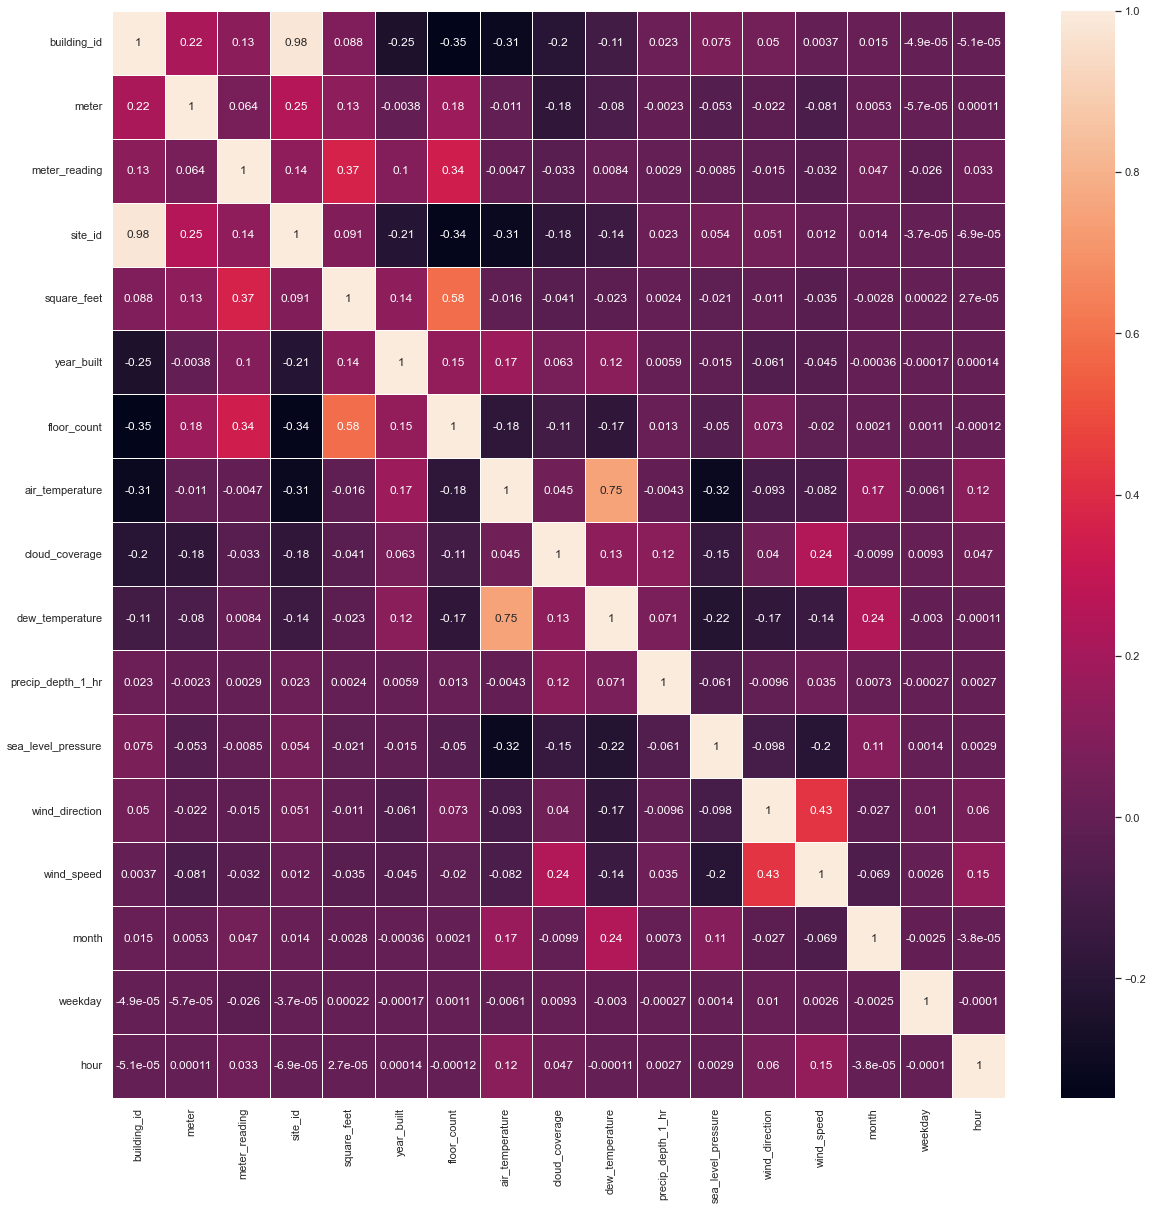

In [124]:
plt.figure(figsize=(20,20))
sns.heatmap(train_merged.corr(), annot=True, linewidths=.5)
plt.show()

In [57]:
# Plotting distributions before normalization
# X_train.floor_count.plot(kind='kde')
# X_train.square_feet.plot(kind='kde')
# plt.show()

In [58]:
# Normalizing columns using log1P normalization
X_train['floor_count'] = np.log1p(X_train['floor_count'])
X_train['square_feet'] = np.log1p(X_train['square_feet'])
y_train = np.log1p(y_train)

<AxesSubplot:ylabel='Density'>

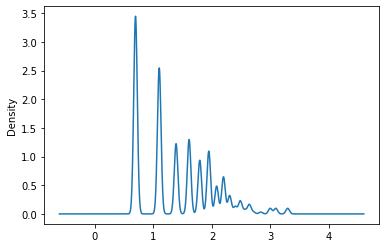

In [59]:
# Plotting distributions after normalization
X_train.floor_count.plot(kind='kde')
# X_train.groupby('building_id').square_feet.plot(kind='kde')

In [60]:
# plt.figure(figsize=(10,10))
# sns.heatmap(weather_train.corr(), annot=True, linewidths=.5)

In [16]:
train_merged['meter_reading']=np.log1p(train_merged['meter_reading'])

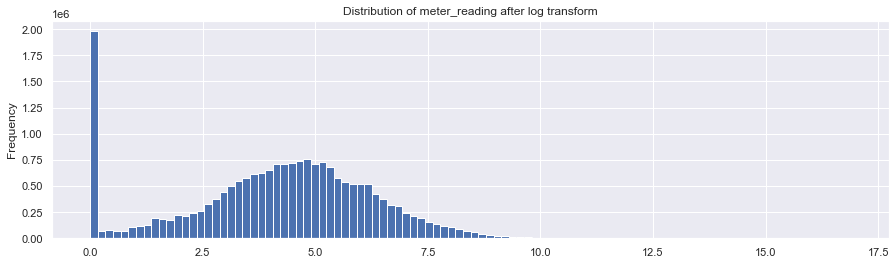

In [106]:
# plotting distribution of output variable
# extremly skewed
train_merged['meter_reading'].plot(kind='hist',
                        bins=100,
                        figsize=(15, 4),
                       title='Distribution of meter_reading after log transform')
plt.show()

c:\python\python391\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


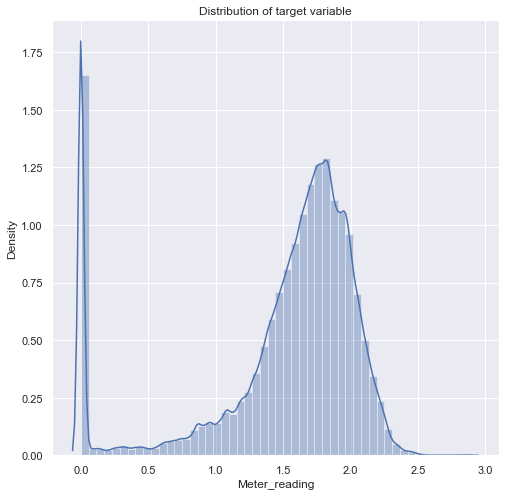

In [100]:
plt.figure(figsize=(8,8))
sns.distplot(train['meter_reading'])
plt.xlabel("Meter_reading")
plt.title("Distribution of target variable")
plt.show()

In [76]:
sns.set_style('darkgrid')

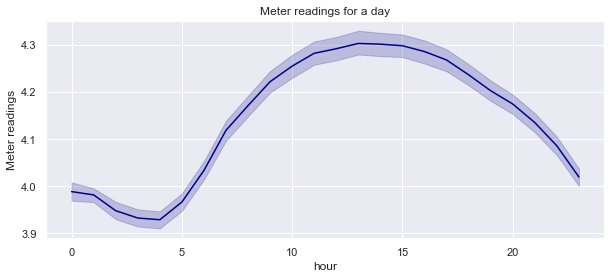

In [117]:
#Lets check the hour wise usage of power
plt.figure(figsize=(10,4))
hour= train_merged.groupby(['timestamp','hour']).meter_reading.mean().reset_index()
sns.lineplot(x=hour['hour'], y=hour['meter_reading'], color='darkblue')
plt.ylabel("Meter readings")
plt.title("Meter readings for a day")
plt.show()

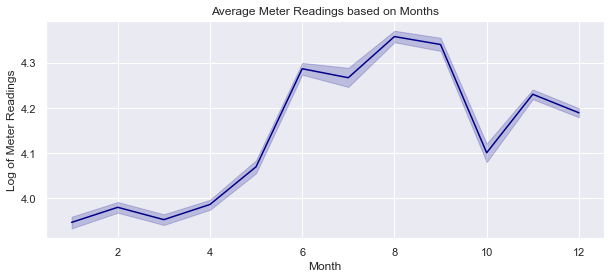

In [118]:
#Lets check the month wise usage of power
plt.figure(figsize=(10,4))
month_df= train_merged.groupby(['timestamp','month']).meter_reading.mean().reset_index()
sns.lineplot(x=month_df['month'], y=month_df['meter_reading'], color='darkblue')

plt.xlabel("Month")
plt.ylabel("Log of Meter Readings")
plt.title("Average Meter Readings based on Months")
plt.show()

[Text(0, 0, 'Electricity'),
 Text(1, 0, 'Chilledwater'),
 Text(2, 0, 'Steam'),
 Text(3, 0, 'Hotwater')]

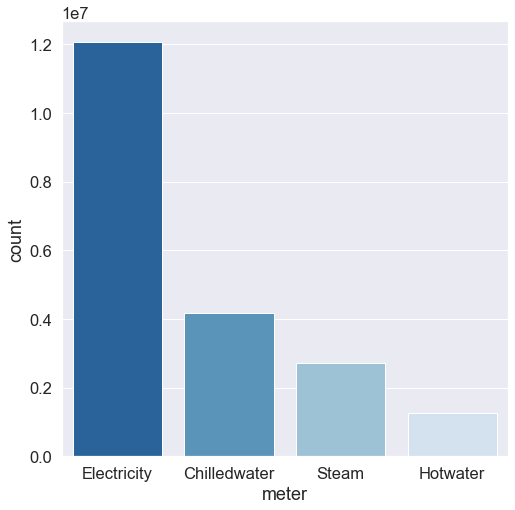

In [85]:
#Count plot for each meter category
meter_type=['Electricity', 'Chilledwater', 'Steam', 'Hotwater']
sns.set(font_scale = 1.5)
plt.figure(figsize=(8,8))
p=sns.countplot(x='meter', data=train_merged,palette="Blues_r")
p.set_xticklabels(meter_type)

[Text(0, 0, 'Electricity'),
 Text(1, 0, 'Chilledwater'),
 Text(2, 0, 'Steam'),
 Text(3, 0, 'Hotwater')]

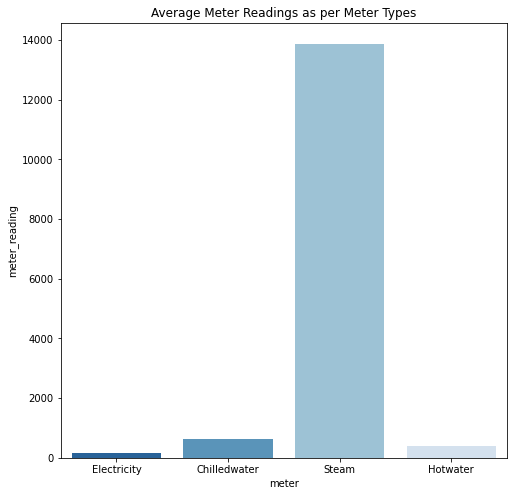

In [10]:
#Meter readings for each meter category
# {0: 'electricity', 1: 'chilledwater', 2: 'steam', 3: 'hotwater'}
meter_type=['Electricity', 'Chilledwater', 'Steam', 'Hotwater']
plt.figure(figsize=(8,8))
meter_df= train_merged.groupby('meter').meter_reading.mean().reset_index()
p= sns.barplot(x='meter', y='meter_reading', data=meter_df, palette="Blues_r")
plt.title("Average Meter Readings as per Meter Types")
p.set_xticklabels(meter_type)

In [11]:
meter_df

,meter,meter_reading
0,0,170.825638
1,1,633.363953
2,2,13882.187500
3,3,385.866791


<AxesSubplot:xlabel='count', ylabel='primary_use'>

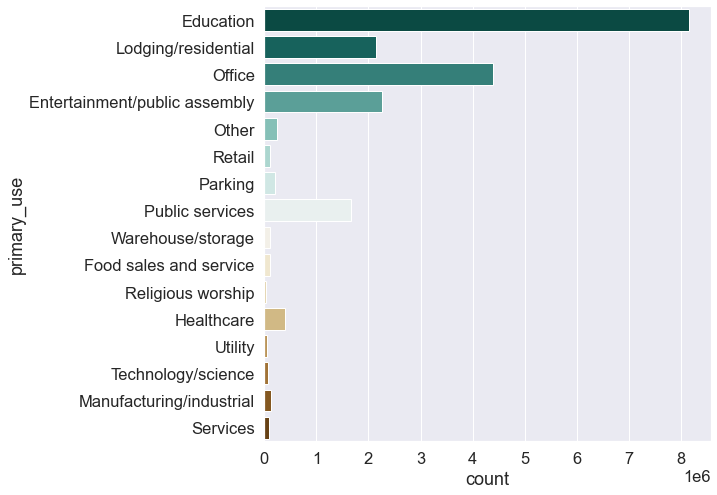

In [93]:
#Primary usage plots
#Count plot for each primary usage category
plt.figure(figsize=(8,8))
sns.countplot(y='primary_use', data=train_merged,palette="BrBG_r")

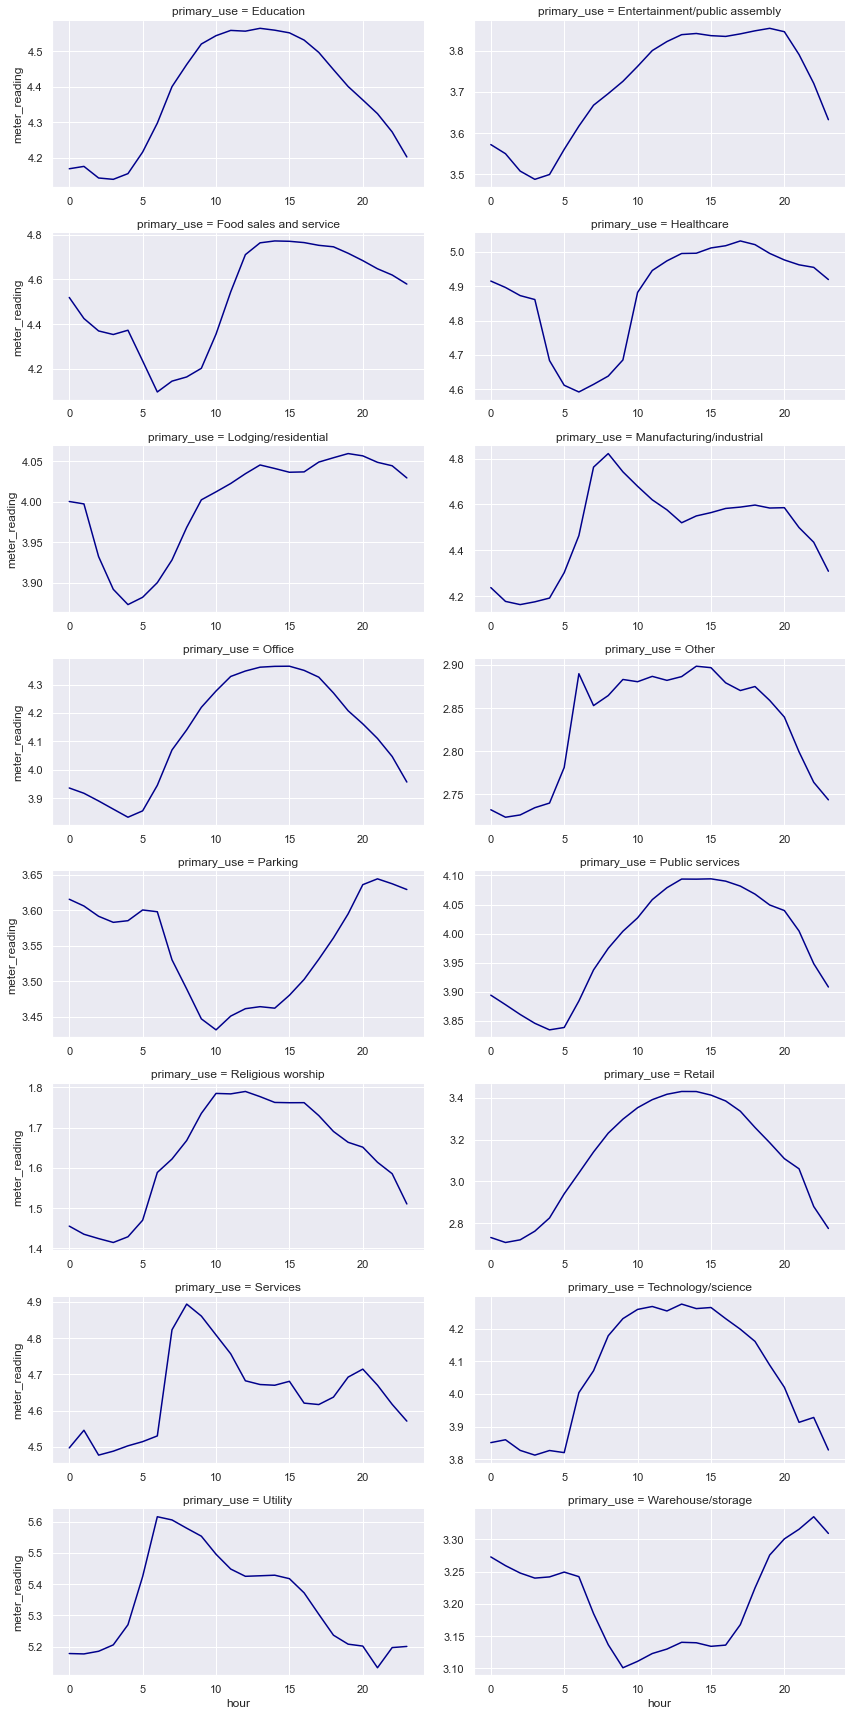

In [95]:
#Hourly average readings based on type of buildings
sns.set(font_scale = 1)
hour_use_df= train_merged.groupby(['hour', 'primary_use']).meter_reading.mean().reset_index()
p=sns.FacetGrid(hour_use_df, col='primary_use', col_wrap=2, height=3, aspect=2, sharey=False, sharex=False)
p.map(sns.lineplot, 'hour', 'meter_reading', color='darkblue')
plt.show()

In [12]:
primary_use_df= train_merged.groupby(['primary_use']).meter_reading.mean().reset_index()
primary_use_df

,primary_use,meter_reading
0,Education,4585.091797
1,Entertainment/public assembly,473.880676
2,Food sales and service,304.908020
3,Healthcare,738.597595
4,Lodging/residential,279.710449
5,Manufacturing/industrial,285.897003
6,Office,526.504395
7,Other,138.703781
8,Parking,169.386795
9,Public services,288.237854


In [13]:
primary_meter_df= train_merged.groupby(['primary_use','meter']).meter_reading.mean().reset_index()
primary_meter_df

,primary_use,meter,meter_reading
0,Education,0,245.430573
1,Education,1,736.632568
2,Education,2,30607.160156
3,Education,3,300.172577
4,Entertainment/public assembly,0,116.197159
5,Entertainment/public assembly,1,1526.434570
6,Entertainment/public assembly,2,615.157715
7,Entertainment/public assembly,3,1300.619019
8,Food sales and service,0,94.794983
9,Food sales and service,1,372.636536


In [16]:
primary_meter_sq_df= train_merged.where(train_merged['square_feet']<5000).groupby(['primary_use','meter']).meter_reading.mean().reset_index()
primary_meter_sq_df

,primary_use,meter,meter_reading
0,Education,0.0,15.908084
1,Education,1.0,0.079918
2,Entertainment/public assembly,0.0,6.165064
3,Lodging/residential,0.0,3.003463
4,Manufacturing/industrial,0.0,63.569344
5,Office,0.0,10.258684
6,Other,0.0,17.959421
7,Other,1.0,733.031616
8,Parking,0.0,16.808174
9,Public services,0.0,10.891889


In [125]:
train_merged['meter_reading']= np.expm1(train_merged['meter_reading'])

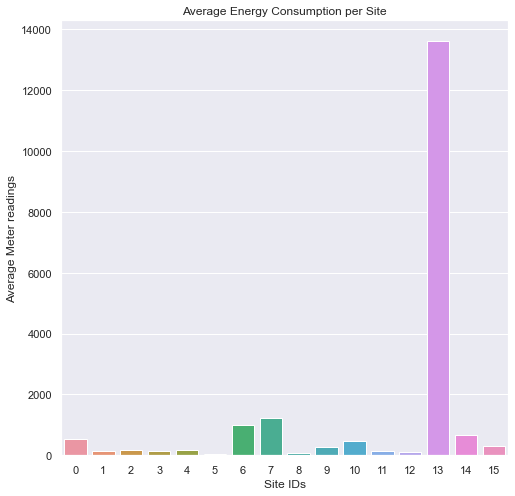

In [126]:
#Sitewise consumption
plt.figure(figsize=(8,8))
site_df= train_merged.groupby(['site_id']).meter_reading.mean().reset_index()
sns.barplot(x=site_df['site_id'], y=site_df['meter_reading'])
plt.ylabel("Average Meter readings")
plt.xlabel("Site IDs")
plt.title("Average Energy Consumption per Site")
plt.show()

In [121]:
print(train_merged[train_merged.meter_reading == train_merged.meter_reading.max()])

         building_id  meter           timestamp  meter_reading  site_id  \
8907488         1099      2 2016-06-13 09:00:00      16.902212       13   

        primary_use  square_feet  year_built  floor_count  air_temperature  \
8907488   Education       332884         NaN          NaN         19.40625   

         cloud_coverage  dew_temperature  precip_depth_1_hr  \
8907488             NaN        17.203125                0.0   

         sea_level_pressure  wind_direction  wind_speed  month  weekday  hour  \
8907488              1014.5            50.0    6.199219      6        0     9   

         is_holiday  
8907488       False  
